<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/cEgF0YknpZw

# **Prepare environment**

## Install Detectron2

In [ ]:
python -m pip install -e .

### check requirement

In [1]:
!python3 -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python3 -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# python -m pip install git+https://github.com/facebookresearch/detectron2.git

Python konnte nicht gefunden werden. F�hren Sie die Verkn�pfung ohne Argumente aus, um sie �ber den Microsoft Store zu installieren, oder deaktivieren Sie diese Verkn�pfung unter 
fatal: destination path 'detectron2' already exists and is not an empty directory.
Das System kann die angegebene Datei nicht finden.


### import package

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


import detectron2
print(detectron2.__file__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Sep_12_02:55:00_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.77
Build cuda_12.6.r12.6/compiler.34841621_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6
c:\Users\ba7jd2\Work Folders\Documents\Projects\WoodFeature\xAI_Masterthesis_Pan\Train_code\Segmentation\Detectron\202406_Detectron2\detectron2\detectron2\__init__.py


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt


plt.rcParams['font.sans-serif'] = ['Arial']  # or any other font you have installed
plt.rcParams['font.family'] = 'sans-serif'


# import some common libraries
import pandas as pd
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

matplotlib data path: c:\Users\ba7jd2\AppData\Local\anaconda3\envs\test\lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\ba7jd2\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\ba7jd2\.matplotlib
Using fontManager instance from C:\Users\ba7jd2\.matplotlib\fontlist-v390.json


## Test on image

### show image

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\ba7jd2\\AppData\\Local\\anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\ba7jd2\\AppData\\Local\\anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\ba7jd2\\AppData\\Local\\anaconda3\\envs\\test\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant=

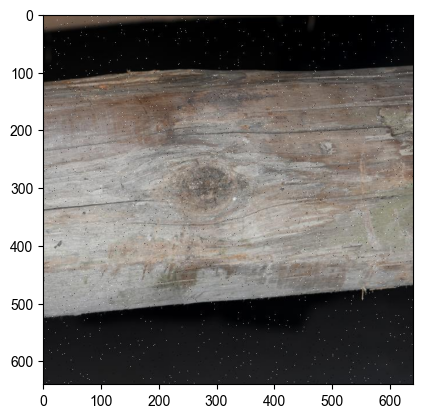

In [4]:
image_path = r"C:\Users\ba7jd2\Work Folders\Desktop\009_0871_JPG.rf.037c4488985845c16afc15124c720b3e.jpg"
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# cv2.imshow("image", image)

### create and test config

In [ ]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(image)

[11/04 13:52:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[Checkpointer] Loading from C:\Users\ba7jd2/.torch/iopath_cache\detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600\model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:184 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:87 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:100 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:91 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastXPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:41 [kernel]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]


#### show outputs

In [6]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([], dtype=torch.int64)
Boxes(tensor([], size=(0, 4)))


#### show img

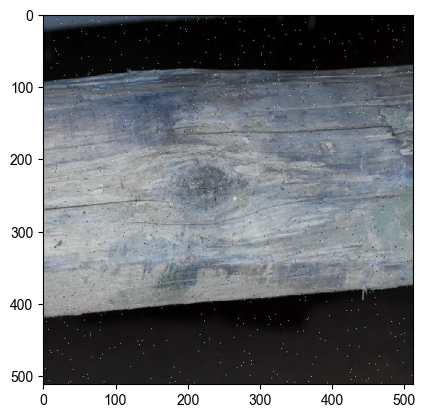

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

# **Preparation Data**

## *Server*

### Data loader(server)

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wood_train", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train")
register_coco_instances("wood_val", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid")
register_coco_instances("wood_test", {}, "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/_annotations.coco.json", "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test")


train_metadata = MetadataCatalog.get("wood_train")
train_dataset_dicts = DatasetCatalog.get("wood_train")

val_metadata = MetadataCatalog.get("wood_val")
val_dataset_dicts = DatasetCatalog.get("wood_val")

test_metadata = MetadataCatalog.get("wood_test")
test_dataset_dicts = DatasetCatalog.get("wood_test")


### Check sample(server)

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])  # Read image in BGR format
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)  # Convert BGR to RGB
    vis = visualizer.draw_dataset_dict(d)
    
    vis_img = vis.get_image()  # Get the visualized image in RGB format
    plt.imshow(vis_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
# # Visualize some random samples
# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()


## *Local*

### Data loader(local)

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wood_train", {}, "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json", "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/train")
register_coco_instances("wood_val", {}, "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/valid/_annotations.coco.json", "/Users/holmes/Documents/UNI-Bamberg/Arbeiten/Datensatz/Selfmade/3_iphone_domini_seg/Dominik-seg.v4i.coco-segmentation/valid")

train_metadata = MetadataCatalog.get("wood_train")
train_dataset_dicts = DatasetCatalog.get("wood_train")

val_metadata = MetadataCatalog.get("wood_val")
val_dataset_dicts = DatasetCatalog.get("wood_val")


### Check sample(local)

In [ ]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# **Training**

## *Train(server)*

In [ ]:
import torch
torch.cuda.empty_cache()
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Model Config .yaml

In [ ]:
project_name="detectron2"

# # model rcnn r50 fpn 3x
# task_name="test_r50_11_0617"
# model_name = "mask_rcnn_R_50_FPN_3x"
# model_config = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

# model rcnn r101 fpn 3x
task_name="r101_test_6_0618_server"
model_name = "mask_rcnn_R_101_FPN_3x"
model_config = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"


### Model Config .py

In [ ]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig


# model rcnn r 50 fpn using Large-Scale Jitter and Longer Training Schedule
task_name="r50_400_test_1_0618_server"
model_name = "mask_rcnn_R_50_FPN_400ep_LSJ"
model_config = f'/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'

# # model rcnn x101 fpn using Large-Scale Jitter and Longer Training Schedule
# task_name="test_x101_11_0617_local"
# model_name = "mask_rcnn_R_101_FPN_400ep_LSJ.py"
# model_config = "/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2/detectron2/model_zoo/configs/new_baselines/mask_rcnn_R_101_FPN_400ep_LSJ.py"

# cfg = LazyConfig.to_py(get_config("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py"))

# cfg = LazyConfig.load(model_config)
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig

cfg = get_config("new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ.py")

print(cfg)


### Save .csv

In [ ]:
import math

Dataset_version = "v1"
train_amount = 1113
img_per_batch = 16
max_iter = 20869
total_epoch =  math.ceil(max_iter / (train_amount // img_per_batch))
base_lr = 0.00025
poly_power = 1

# test_record_csv = "/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/detectron2_test_record.csv"

# # Save in csv
# new_row = [
#     task_name,
#     model_name,
#     Dataset_version,
#     train_amount,
#     img_per_batch,
#     max_iter,
#     total_epoch,
#     base_lr,
#     poly_power,
#     "none"
# ]

# df = pd.read_csv(test_record_csv, header=None)

# df.loc[len(df)] = new_row

# df.to_csv(test_record_csv, header=False, index=False)

### config .yaml

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg['OUTPUT_DIR'] = rf"/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}"
output_directory = cfg['OUTPUT_DIR']
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

cfg.merge_from_file(model_zoo.get_config_file(model_config))
cfg.MODEL.DEVICE = "cpu"

cfg.DATASETS.TRAIN = ("wood_train",)
cfg.DATASETS.TEST = ("wood_val",)
cfg.DATALOADER.NUM_WORKERS = 2 # number of data loading threads
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = img_per_batch # images per batch
cfg.SOLVER.BASE_LR = base_lr # learning rate
cfg.SOLVER.MAX_ITER = max_iter # iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

# # save the configuration
# import yaml

# config_yaml_path = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}/config.yaml"
# directory = os.path.dirname(config_yaml_path)

# if not os.path.exists(directory):
#     os.makedirs(directory)

# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)
    

### Config .py

In [ ]:
from detectron2.engine import DefaultTrainer

cfg.train.output_dir = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}"
output_directory = cfg.train.output_dir
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

cfg.dataloader.train.dataset.names = "wood_train"
cfg.dataloader.test.dataset.names = "wood_val"
cfg.dataloader.evaluator.dataset_name = "wood_test"

cfg.dataloader.train.dataset._target_ = "wood_train"
cfg.dataloader.train._target_ = "wood_train"

cfg.dataloader.test.dataset._target_ = "wood_val"
cfg.dataloader.test._target_ = "wood_val"

cfg.dataloader.train.total_batch_size = img_per_batch
cfg.dataloader.train.num_workers = 3
cfg.train.max_iter = max_iter
cfg.optimizer.lr = base_lr
# cfg.optimizer.weight_decay = None

cfg.model.roi_heads.num_classes = 3
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.train.output_dir, exist_ok=True)

# !
# trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
# trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

# # save the configuration
# import yaml

# config_yaml_path = rf"/home/jpan/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/{task_name}/config.yaml"
# directory = os.path.dirname(config_yaml_path)

# if not os.path.exists(directory):
#     os.makedirs(directory)

# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)

print(cfg)

In [ ]:
print(cfg.dataloader.train.dataset.names)
print(cfg.dataloader.test.dataset.names)
print(cfg.dataloader.train)


In [ ]:
import logging

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from detectron2.engine import (
    AMPTrainer,
    SimpleTrainer,
    default_setup,
    default_writers,
    hooks,
    launch,
)
from detectron2.engine.defaults import create_ddp_model
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm

logger = logging.getLogger("detectron2")

class Args:
    config_file = model_config
    resume = False
    eval_only = False
    num_gpus = 1
    num_machines = 1
    machine_rank = 0
    dist_url = "tcp://127.0.0.1:50152"
    opts = []

args = Args()

def do_test(cfg, model):
    if "evaluator" in cfg.dataloader:
        ret = inference_on_dataset(
            model,
            instantiate(cfg.dataloader.test),
            instantiate(cfg.dataloader.evaluator),
        )
        print_csv_format(ret)
        return ret

def do_train(args, cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger("detectron2")
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)
    print("model")
    
    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)
    print("model2")


    train_loader = instantiate(cfg.dataloader.train)
    print("model3")


    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)
    checkpointer = DetectionCheckpointer(
        model,
        cfg.train.output_dir,
        trainer=trainer,
    )
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            (
                hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
                if comm.is_main_process()
                else None
            ),
            hooks.EvalHook(cfg.train.eval_period, lambda: do_test(cfg, model)),
            (
                hooks.PeriodicWriter(
                    default_writers(cfg.train.output_dir, cfg.train.max_iter),
                    period=cfg.train.log_period,
                )
                if comm.is_main_process()
                else None
            ),
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=args.resume)
    if args.resume and checkpointer.has_checkpoint():
        start_iter = trainer.iter + 1
    else:
        start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

def main(args):
    cfg = LazyConfig.load(args.config_file)
    cfg = LazyConfig.apply_overrides(cfg, args.opts)
    default_setup(cfg, args)

    if args.eval_only:
        model = instantiate(cfg.model)
        model.to(cfg.train.device)
        model = create_ddp_model(model)
        DetectionCheckpointer(model).load(cfg.train.init_checkpoint)
        print(do_test(cfg, model))
    else:
        do_train(args, cfg)

# 在 Jupyter Notebook 中运行
if __name__ == "__main__":
    main(args)


In [ ]:
print(cfg)

### clearml

In [ ]:
#clearml mac
# %env CLEARML_WEB_HOST=https://app.clear.ml
# %env CLEARML_API_HOST=https://api.clear.ml
# %env CLEARML_FILES_HOST=https://files.clear.ml
# %env CLEARML_API_ACCESS_KEY=QO1VBBX9J2S2VYILQTGI
# %env CLEARML_API_SECRET_KEY=ERuc1S6o5SirQGugvYXDFjH9b9aNi0u8S3rpALzXMa8YPSLDMW

# clearml win
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=Z4YDBU13VPOFHBHF8667
%env CLEARML_API_SECRET_KEY=JMzvRXn76AT83WuFJfS0FBGCY8c5TccbH5XboTYztrWqwzDdyn

from clearml import Task

#Clear ML Initialization
cl_task = Task.init(project_name=project_name,task_name=task_name)
logger = cl_task.get_logger()

### Train

In [ ]:
trainer.train() #Start the training process
cl_task.close()

# Inference & evaluation using the trained model

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = '/Users/holmes/Desktop/test_10_0610_model_final.pth'  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Function to convert binary masks to polygons      
def binary_mask_to_polygons(binary_mask, tolerance=1):
    polygons = []
    # Convert boolean mask to uint8
    binary_mask = binary_mask.astype(np.uint8)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if len(contour) > 4:
            contour = contour.flatten().tolist()
            polygons.append([[contour[i], contour[i + 1]] for i in range(0, len(contour), 2)])
    return polygons


## Verify segmentation on random validation images

In [ ]:
# Randomly select one image from validation dataset and visualize predictions
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])  # Read image in BGR format
    im_rgb = im[:, :, ::-1]  # Convert BGR to RGB
    outputs = predictor(im_rgb)  # Get predictions from the model
    
    # Create a Visualizer instance
    v = Visualizer(im_rgb,  # Use RGB image
                   metadata=val_metadata,
                   scale=0.5,
                   # instance_mode=ColorMode.IMAGE_BW  # Optionally remove colors of unsegmented pixels
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Get the visualized image in RGB format
    out_img = out.get_image()
    
    # Display the image using matplotlib
    plt.imshow(out_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
    # Save the output image
    original_file_name = os.path.basename(d["file_name"])
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(cfg.OUTPUT_DIR, new_file_name)
    plt.imsave(output_file_path, out_img)  # Save as RGB format


## Export with json

In [ ]:
import random
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode


# Randomly select one image from validation dataset and visualize predictions
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])  # Read image in BGR format
    im_rgb = im[:, :, ::-1]  # Convert BGR to RGB
    outputs = predictor(im_rgb)  # Get predictions from the model
    
    # Create a Visualizer instance
    v = Visualizer(im_rgb,  # Use RGB image
                   metadata=val_metadata,
                   scale=0.5,
                   # instance_mode=ColorMode.IMAGE_BW  # Optionally remove colors of unsegmented pixels
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Get the visualized image in RGB format
    out_img = out.get_image()
    
    # Display the image using matplotlib
    plt.imshow(out_img)
    plt.axis('off')  # Hide the axes for better display
    plt.show()
    
    # Save the output image
    original_file_name = os.path.basename(d["file_name"])
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(cfg.OUTPUT_DIR, new_file_name)
    plt.imsave(output_file_path, out_img)  # Save as RGB format
    
    # Save the detection results as JSON
    instances = outputs["instances"].to("cpu")
    pred_classes = instances.pred_classes.tolist()
    pred_boxes = instances.pred_boxes.tensor.tolist()
    pred_scores = instances.scores.tolist()
    
    # Extract masks and convert to polygons
    pred_masks = instances.pred_masks.numpy()
    pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]
    
    # Organize results per instance
    detection_results = []
    for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
        instance_result = {
            "class": cls,
            "box": box,
            "score": score,
            "mask": [{"polygon": polygon} for polygon in polygons]
        }
        detection_results.append(instance_result)
    
    result_dict = {
        "file_name": d["file_name"],
        "instances": detection_results
    }
    
    json_file_name = f"test_{original_file_name.split('.')[0]}.json"
    json_output_file_path = os.path.join(cfg.OUTPUT_DIR, json_file_name)
    with open(json_output_file_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)


## Export folder results with json

In [ ]:
input_folder = '/Users/holmes/Documents/UNI-Bamberg/Arbeiten/RAW-DATA/FARO_pano_pc'
output_folder = '/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Segmentation/Detectron/202406_Detectron2/r101_test_6_0618_server/more_test'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for file_name in os.listdir(input_folder):
    file_path = os.path.join(input_folder, file_name)
    if file_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        im = cv2.imread(file_path)  # Read image in BGR format
        if im is None:
            continue
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        outputs = predictor(im_rgb)  # Get predictions from the model
        
        v = Visualizer(im_rgb, metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        out_img = out.get_image()[:, :, ::-1]  # Convert RGB to BGR for OpenCV

        # plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        # plt.axis('off')
        # plt.show()

        test_name = f"det_seg_{file_name}"

        output_image_path = os.path.join(output_folder, f"{test_name}")
        cv2.imwrite(output_image_path, out_img)

        # save JSON
        instances = outputs["instances"].to("cpu")
        pred_classes = instances.pred_classes.tolist()
        pred_boxes = instances.pred_boxes.tensor.tolist()
        pred_scores = instances.scores.tolist()
        pred_masks = instances.pred_masks.numpy()
        pred_polygons = [binary_mask_to_polygons(mask) for mask in pred_masks]

        detection_results = []
        for cls, box, score, polygons in zip(pred_classes, pred_boxes, pred_scores, pred_polygons):
            instance_result = {
                "class": cls,
                "box": box,
                "score": score,
                "mask": [{"polygon": polygon} for polygon in polygons]
            }
            detection_results.append(instance_result)
        
        result_dict = {
            "file_name": file_name,
            "instances": detection_results
        }
        
        json_output_file_path = os.path.join(output_folder, f"{test_name.split('.')[0]}.json")
        with open(json_output_file_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)


### Others

In [ ]:
def run_inference_on_custom_image(image_path, output_dir, predictor, val_metadata):
    im = cv2.imread(image_path)
    outputs = predictor(im)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW  
    )
    
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    
    original_file_name = os.path.basename(image_path)
    new_file_name = f"test_{original_file_name}"
    output_file_path = os.path.join(output_dir, new_file_name)
    plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0)
    # plt.close() 

custom_image_path = "/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/test/Model_3_0020_jpeg.rf.b1ada19a12423f765881f57d7f2223d6.jpg" 
output_dir = cfg.OUTPUT_DIR
run_inference_on_custom_image(custom_image_path, output_dir, predictor, val_metadata)


## Test on mac

## Further check

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wood_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "wood_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

**Load a new image and segment it.**

In [ ]:
new_im = cv2.imread(r"B:\01_Study\Uni-Bamberg\Work\Holzprojects\Datasets_local\03_Domini_ip13\Dominik-seg.v4i.coco-segmentation\test\Model_5_0016_jpeg.rf.04622e1c6175ec13b0be7f653916a02d.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])

**Process multiple images in a directory and save the results in an output directory**

In [ ]:
# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segment images and save object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


**Generate plots to understand the objects**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results/output_objects.csv"  # Update with your CSV file path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()




In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/3D-EM-Platelet/test_results_instance"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")


# END

**Interested in panoptic segmentation?**

In [ ]:
my_new_image = cv2.imread("/content/drive/MyDrive/ColabNotebooks/data/street_small.jpg")
cv2_imshow(my_new_image)

In [ ]:
# Inference with instance segmentation
cfg_inst = get_cfg()
cfg_inst.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_inst.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg_inst.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg_inst)
outputs = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_inst.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

**Panoptic segmentation = Instance segmentation + Semantic Segmentation**





In [ ]:
# Inference with a panoptic segmentation model
cfg_pan = get_cfg()
cfg_pan.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg_pan.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg_pan)
panoptic_seg, segments_info = predictor(new_im)["panoptic_seg"]
v = Visualizer(new_im[:, :, ::-1], MetadataCatalog.get(cfg_pan.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image()[:, :, ::-1])